In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import cv2
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seed = 1

cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

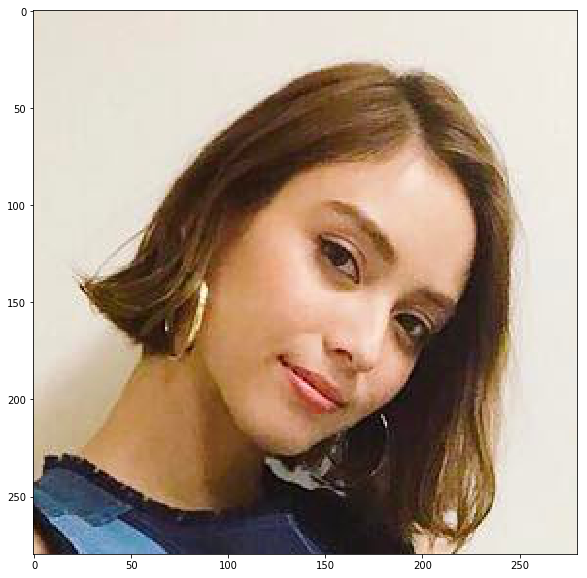

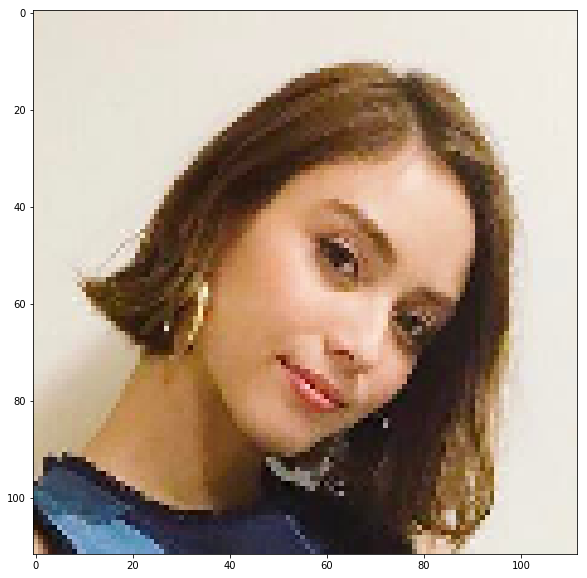

In [3]:
# hr
hr_img = cv2.imread('./data/karen/karen_hr.jpg')
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
hr_img = hr_img[80:360, 380:660]
plt.figure(figsize = (10, 10))
plt.imshow(hr_img)
plt.show()

# lr
lr_img = cv2.resize(hr_img, None, fx = 0.4, fy = 0.4, interpolation = cv2.INTER_CUBIC)
plt.figure(figsize = (10, 10))
plt.imshow(lr_img)
plt.show()

In [4]:
def createDownscaledImage (hr_img, scalingFactor = 0.1):
    return cv2.resize(hr_img, None, fx = scalingFactor, fy = scalingFactor, interpolation = cv2.INTER_CUBIC)

def showImage (img):
    show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (10, 10))
    plt.imshow(show_img)
    plt.show()

def imshow (output, figsize=(10, 10)):
    plt_img = np.clip(output.data.numpy()[0].transpose((1, 2, 0)), 0, 1)
    plt.figure(figsize = (10, 10))
    plt.imshow(plt_img)
    plt.show()

In [5]:
class PlainBlock(nn.Module):
    def __init__(self, in_d, out_d, stride=1):
        super(PlainBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_d, out_d, 3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_d, out_d, 3, stride=1, padding=1, bias=False)
        
        if in_d is out_d:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_d, out_d, 1, stride, bias=False)
            )
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out
        
class BottleneckBlock(nn.Module):
    def __init__(self, in_d, out_d, stride=1):
        super(BottleneckBlock, self).__init__()
        mid_d = int(out_d / 4)
        if mid_d < 1:
            mid_d = 1
        
        self.conv1 = nn.Conv2d(in_d, mid_d, 1)
        self.conv2 = nn.Conv2d(mid_d, mid_d, 3, stride, padding=1)
        self.conv3 = nn.Conv2d(mid_d, out_d, 1)
        
        if in_d is out_d:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_d, out_d, 1, stride, bias=False)
            )
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, Block, blocks):
        super(ResNet, self).__init__()
        
        _layers = []
        for index in range(1, len(blocks)):
            _layers.append(Block(blocks[index - 1], blocks[index]))
        self.layer = nn.Sequential(*_layers)
        
    def forward(self, x):
        return self.layer(x)
                
class DeepImagePriorSR(nn.Module):
    def __init__(self, input_shape, blocks=[64, 128, 256, 128, 64, 32]):
        super(DeepImagePriorSR, self).__init__()
        self.input_shape = input_shape
        resnet_blocks = [input_shape[0]]
        resnet_blocks.extend(blocks)
        self.resnet = ResNet(BottleneckBlock, resnet_blocks)
        self.layer = nn.Sequential(
            nn.Conv2d(blocks[len(blocks) - 1], 3, 1),
            nn.Sigmoid()
        )
        
    def make_z(self):
        return torch.randn([1, self.input_shape[0], self.input_shape[1], self.input_shape[2]])
        
    def forward(self, x):
        out = self.resnet(x)
        out = self.layer(out)
        return out
        

In [6]:
class Lanczos(nn.Module):
    def __init__(self, in_d, factor, kernel_width, support=1):
        super(Lanczos, self).__init__()
        
        self.kernel = self.get_kernel(factor, kernel_width, support)
        
        self.sampler = nn.Conv2d(in_d, in_d, kernel_size=self.kernel.shape, stride=factor, padding=0)
        self.sampler.weight.data[:] = 0
        self.sampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(in_d):
            self.sampler.weight.data[i, i] = kernel_torch
            
        if  self.kernel.shape[0] % 2 == 1: 
            pad = int((self.kernel.shape[0] - 1) / 2.)
        else:
            pad = int((self.kernel.shape[0] - factor) / 2.)

        self.padding = nn.ReplicationPad2d(pad)
        
    def get_kernel(self, factor, kernel_width, support=1):
        kernel = np.zeros([kernel_width, kernel_width])
        
        center = (kernel_width) / 2.0
        
        pi2 = np.pi * np.pi
        
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                di = abs(i - center) / factor
                dj = abs(j - center) / factor
                
                val = 1
                if di != 0:
                    val *= support * np.sin(np.pi * di) * np.sin(np.pi * di / support) / (pi2 * di * di)
                if dj != 0:
                    val *= support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support) / (pi2 * dj * dj)
                
                kernel[i][j] = val
                
        kernel /= kernel.sum()
        
        return kernel
    
    def forward(self, x):
        out = self.padding(x)
        out = self.sampler(out)
        return out

In [19]:
model = DeepImagePriorSR([32, 128, 128], [32, 64, 128, 64, 64, 32])

In [20]:
downsampler = Lanczos(3, 2, 8, 10)

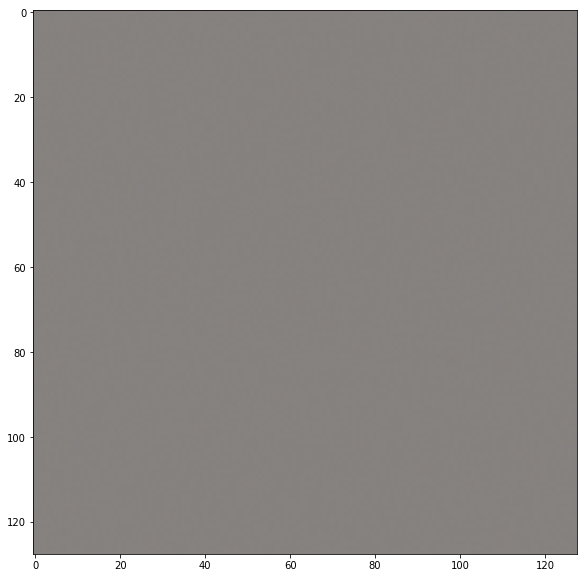

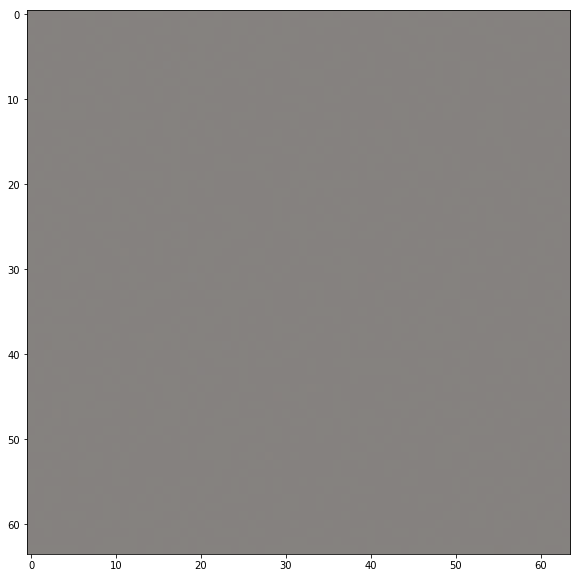

output: torch.Size([1, 3, 128, 128]), downsampled: torch.Size([1, 3, 64, 64])


In [21]:
if cuda:
    input = model.make_z().cuda()
else:
    input = model.make_z()

output = model(Variable(input))
d_output = downsampler(output)
if cuda:
    imshow(output.cpu())
    imshow(d_output.cpu())
else:
    imshow(output)
    imshow(d_output)
print("output: {}, downsampled: {}".format(output.shape, d_output.shape))